In [1]:
'''
【项目08】  电商打折套路解析

作业要求
1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少
   
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路

'''

"\n【项目08】  电商打折套路解析\n\n作业要求\n1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”\n要求：\n① 计算得到：商品总数、品牌总数\n② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）\n③ 未参与双十一当天活动的商品，在双十一之后的去向如何？\n④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？\n   * 用bokeh绘制柱状图表示\n提示：\n① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称\n   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）\n② 数据的“店名”字段为品牌的唯一标识\n③ 按照商品销售节奏分类，我们可以将商品分为7类\n   A. 11.11前后及当天都在售 → 一直在售\n   B. 11.11之后停止销售 → 双十一后停止销售\n   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售\n   D. 11.11开始销售且当天停止 → 仅双十一当天有售\n   E. 11.5 - 11.10 → 双十一前停止销售\n   F. 仅11.11当天停止销售 → 仅双十一当天停止销售\n   G. 11.12开始销售 → 双十一后上架\n④ 未参与双十一当天活动的商品，可能有四种情况：\n   con1 → 暂时下架（F）\n   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')\n   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）\n   con4 → 彻底下架（E中部分数据），可忽略\n⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）\n   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少\n   \n2、哪些商品真的在打折呢？\n要求：\n① 针对每个商品，评估其打折的情况\n② 针对在打折的商品，其折扣率是多少\n   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量\n③ 按照品牌分析，不同品牌的打折力

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show,output_file
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [2]:
'''
1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少

'''

"\n1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”\n要求：\n① 计算得到：商品总数、品牌总数\n② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）\n③ 未参与双十一当天活动的商品，在双十一之后的去向如何？\n④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？\n   * 用bokeh绘制柱状图表示\n提示：\n① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称\n   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）\n② 数据的“店名”字段为品牌的唯一标识\n③ 按照商品销售节奏分类，我们可以将商品分为7类\n   A. 11.11前后及当天都在售 → 一直在售\n   B. 11.11之后停止销售 → 双十一后停止销售\n   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售\n   D. 11.11开始销售且当天停止 → 仅双十一当天有售\n   E. 11.5 - 11.10 → 双十一前停止销售\n   F. 仅11.11当天停止销售 → 仅双十一当天停止销售\n   G. 11.12开始销售 → 双十一后上架\n④ 未参与双十一当天活动的商品，可能有四种情况：\n   con1 → 暂时下架（F）\n   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')\n   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）\n   con4 → 彻底下架（E中部分数据），可忽略\n⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）\n   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少\n\n"

In [2]:
# 查看数据, 计算商品总数、品牌总数

import os
os.chdir(r'C:\Users\Administrator\Python数据\网易数据分析\1项目资料\项目08电商打折套路解析')
# 创建工作路径

df = pd.read_excel('双十一淘宝美妆数据.xlsx',sheetname=0,header=0,index_col=0)

df_length = len(df)
df_columns = df.columns.tolist()
df.fillna(0,inplace = True)   # 填充缺失值
df['date'] = df.index.day     # 提取销售日期

print('数据量为%i条' % len(df))
print('数据时间周期为：\n', df.index.unique(),len( df.index.unique()))
df.head()

数据量为27642条
数据时间周期为：
 DatetimeIndex(['2016-11-14', '2016-11-13', '2016-11-12', '2016-11-11',
               '2016-11-10', '2016-11-09', '2016-11-08', '2016-11-07',
               '2016-11-06', '2016-11-05'],
              dtype='datetime64[ns]', name='update_time', freq=None) 10


,id,title,price,店名,date
update_time,,,,,
2016-11-14,A2251521828,相宜本草四倍多萃润泽精华保湿霜滋润面霜女补水,79.0,相宜本草,14
2016-11-14,A2251610120,正品相宜本草四倍多萃润泽洁面膏深层清洁滋润补水保湿,29.0,相宜本草,14
2016-11-14,A2251615486,相宜本草红石榴亮白嫩肤水女紧致补水保湿精华爽肤水女秋冬护肤品,108.0,相宜本草,14
2016-11-14,A2252191048,相宜本草红石榴鲜活透亮面贴膜7片补水保湿女化妆品滋润,79.0,相宜本草,14
2016-11-14,A2253094636,相宜本草去死皮膏洁净面部全身温和去角质补水化妆,35.0,相宜本草,14


d1为：
               min  max
id                    
A10027317366    5   14
A10588608182    5   14
A10847151685    5   14
A12229499633    5   10
A12229615671    5   11 
-------
id_11为：
 2335 
-------
商品总数为3502个
-------
双十一当天参与活动的商品总数为2335个，占比为66.68%
-------
品牌总数为22个
 ['相宜本草' '佰草集' '欧莱雅' '美宝莲' '玉兰油' '蜜丝佛陀' '悦诗风吟' 'SKII' '兰芝' '妮维雅' '自然堂' '倩碧'
 '欧珀莱' '美加净' '雅诗兰黛' '资生堂' '兰蔻' '雅漾' '雪花秀' '植村秀' '薇姿' '娇兰']

id_date
       min  max            id 双十一当天是否售卖 type
92      5   14  A10027317366      True    A
93      5   14  A10588608182      True    A
94      5   14  A10847151685      True    A
2334    5   10  A12229499633     False    E
95      5   11  A12229615671      True    B 


result1
 A    1820
B     458
C      39
D      18
E     841
Name: type, dtype: int64


A    1820
B     458
C      39
D      18
E     841
F     242
G      84
Name: type, dtype: int64

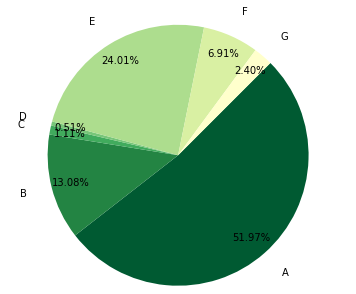

In [3]:
# 双十一当天在售的商品占比情况
# 按照商品销售节奏分类，我们可以将商品分为7类
#   A. 11.11前后及当天都在售 → 一直在售
#   B. 11.11之后停止销售 → 双十一后停止销售
#   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
#   D. 11.11开始销售且当天停止 → 仅双十一当天有售
#   E. 11.5 - 11.10 → 双十一前停止销售
#   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
#   G. 11.12开始销售 → 双十一后上架

data1 = df[['id','title','店名','date']]
#print(data1.head())
# 筛选数据

d1 = data1[['id','date']].groupby(by = 'id').agg(['min','max'])['date']  
print('d1为：\n',d1.head(),'\n-------')
# 统计不同商品的销售开始日期、截止日期

id_11 = data1[data1['date']==11]['id'].unique()
d2 = pd.DataFrame({'id':id_11,'双十一当天是否售卖':True})
print('id_11为：\n',len(id_11),'\n-------')
# 筛选双十一当天售卖的商品id

id_date = pd.merge(d1,d2,left_index=True,right_on='id',how = 'left')
id_date['双十一当天是否售卖'][id_date['双十一当天是否售卖']!=True] = False
#print(id_date.head())
# 合并数据

# m = len(data1['id'].unique())
m = len(d1)
m_11 = len(id_11)
m_11_pre = m_11/m
print('商品总数为%i个\n-------' % m)
print('双十一当天参与活动的商品总数为%i个，占比为%.2f%%\n-------' % (m_11,m_11_pre*100))
print('品牌总数为%i个\n' % len(data1['店名'].unique()),data1['店名'].unique())
# 统计

id_date['type'] = '待分类'
id_date['type'][(id_date['min'] <11)&(id_date['max']>11)] = 'A'      #  A类：11.11前后及当天都在售 → 一直在售
id_date['type'][(id_date['min'] <11)&(id_date['max']==11)] = 'B'     #  B类：11.11之后停止销售 → 双十一后停止销售
id_date['type'][(id_date['min'] ==11)&(id_date['max']>11)] = 'C'     #  C类：11.11开始销售并当天不停止 → 双十一当天上架并持续在售
id_date['type'][(id_date['min'] ==11)&(id_date['max']==11)] = 'D'    #  D类：11.11开始销售且当天停止 → 仅双十一当天有售
id_date['type'][id_date['双十一当天是否售卖']== False] = 'F'         #  F类：仅11.11当天停止销售 → 仅双十一当天停止销售
id_date['type'][id_date['max']<11] = 'E'                             #  E类：11.5 - 11.10 → 双十一前停止销售
id_date['type'][id_date['min'] >11] = 'G'                            #  G类：11.11之后开始销售 → 双十一后上架
print('\nid_date\n',id_date.head(),'\n')
# 商品销售节奏分类

result1 = id_date['type'].value_counts()
result1 = result1.loc[['A','B','C','D','E','F','G']]  # 调整顺序
print('\nresult1\n',result1.head())
# 计算不同类别的商品数量

from bokeh.palettes import brewer
colori = brewer['YlGn'][7]
# 设置调色盘

plt.axis('equal')  # 保证长宽相等
plt.pie(result1,labels = result1.index, autopct='%.2f%%',pctdistance=0.85,labeldistance =1.2,
        startangle=45, radius=1.5,counterclock=False, colors = colori)
# 绘制饼图 startangle  开始角度转个45度  radius半径长度
#labeldistance，文本的位置离圆心有多远，1.1指1.1倍半径的位置
#autopct，圆里面的文本格式，%3.1f%%表示小数有三位，整数有一位的浮点数
#shadow，饼是否有阴影，默认Fasle
#pctdistance，百分比的text离圆心的距离

result1

In [4]:
# 未参与双十一当天活动的商品，在双十一之后的去向如何？
#   con1 → 暂时下架（F）
#   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”）
#   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字），字符串查找特定字符 dataframe.str.contains('预售')
#   con4 → 彻底下架（E中部分数据），可忽略

id_not11 = id_date[id_date['双十一当天是否售卖']==False]  # 筛选出双十一当天没参加活动的产品id
# print('双十一当天没参加活动的商品总数为%i个，占比为%.2f%%\n-------' % (len(id_not11['id'].unique()),len(id_not11)/m*100))
print('双十一当天没参加活动的商品总数为%i个，占比为%.2f%%\n-------' % (len(id_not11),len(id_not11)/m*100))
# title_count1 = id_not11['id'].value_counts()
# id_con21 = title_count1.values.sum()
# id_con21 = len(title_count1.index) 以上三行代码，得到的'id'唯一值，都是1167
# print('id_con21',id_con21)
# print('双十一当天没参加活动的商品销售节奏类别为：\n',id_not11['type'].value_counts().index.tolist())
print('双十一当天没参加活动的商品销售节奏类别为：\n',id_not11['type'].unique())
print('------\nid_not11-->\n',id_not11.head(),'\n')
print('------')
# 找到未参与双十一当天活动的商品id

df_not11 = id_not11[['id','type']]
data_not11 = pd.merge(df_not11,df,on = 'id', how = 'left')
print('data_not11-->\n',data_not11.head(),'\n-----')
# 筛选出未参与双十一当天活动商品id对应的原始数据

id_con1 = id_date['id'][id_date['type'] == 'F'].values
print('id_con1',id_con1[:5],type(id_con1))
# 筛选出con1的商品id
# con1 → 暂时下架（F）→ F类：仅11.11当天停止销售 → 仅双十一当天停止销售

data_con2 = data_not11[data_not11['type']=='E'][['id','title','date']].groupby(by = ['id','title']).count()   # 按照id和title分组（找到id和title一对多的情况）
title_count = data_con2.reset_index()['id'].value_counts()   # 计算id出现的次数，如果出现次数大于1，则说明该商品是更改了title的
id_con2 = title_count[title_count>1].index
# 筛选出con2的商品id

# con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”）

data_con3 = data_not11[data_not11['title'].str.contains('预售')]   # 筛选出title中含有“预售”二字的数据
id_con3 = data_con3['id'].value_counts().index     
# 筛选出con3的商品id
# con3 → 预售（E中部分数据，预售商品的title中包含“预售--contains”二字）

print("未参与双十一当天活动的商品中：\n暂时下架商品的数量为%i个，重新上架商品的数据量为%i个，预售商品的数据量为%i个" 
      % (len(id_con1), len(id_con2), len(id_con3)))

双十一当天没参加活动的商品总数为1167个，占比为33.32%
-------
双十一当天没参加活动的商品销售节奏类别为：
 ['E' 'F' 'G']
------
id_not11-->
       min  max            id 双十一当天是否售卖 type
2334    5   10  A12229499633     False    E
2334    5   14  A12229695732     False    F
2334    5   14  A12454406919     False    F
2334    5   10  A12459717064     False    E
2334    5   10  A12459730213     False    E 

------
data_not11-->
              id type                           title  price    店名  date
0  A12229499633    E  【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水   49.0  相宜本草    10
1  A12229499633    E  【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水   49.0  相宜本草     9
2  A12229499633    E  【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水   49.0  相宜本草     8
3  A12229499633    E  【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水   49.0  相宜本草     7
4  A12229499633    E  【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水   49.0  相宜本草     6 
-----
id_con1 ['A12229695732' 'A12454406919' 'A12568149245' 'A12582438336'
 'A12584353551'] <class 'numpy.ndarray'>
未参与双十一当天活动的商品中：
暂时下架商品的数量为242个，重新上架商品的数据量为26个，预售商品的数据量为453个


In [6]:
print(data_con2.head())
print(data_con2.reset_index().head())
print(title_count.head(10))
print(id_con2[:10])
print(id_con3[:10])

                                                  date
id           title                                    
A12229499633 【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水          6
A12459717064 美宝莲 精致细白无瑕乳液清润型 保湿 补水 滋润清爽正品            6
A12459730213 美宝莲 透净瞬洁净妆乳 120ml  卸妆乳 卸妆液卸妆无残留专柜正品     6
A12460337412 美宝莲 醒润激泽水精华霜50ml 补水 持久保湿 面霜             6
A12544615139 美宝莲宝蓓护唇膏 宝贝护唇膏 润唇膏 唇彩口红保湿 滋润            6
             id                                title  date
0  A12229499633       【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水     6
1  A12459717064         美宝莲 精致细白无瑕乳液清润型 保湿 补水 滋润清爽正品     6
2  A12459730213  美宝莲 透净瞬洁净妆乳 120ml  卸妆乳 卸妆液卸妆无残留专柜正品     6
3  A12460337412          美宝莲 醒润激泽水精华霜50ml 补水 持久保湿 面霜     6
4  A12544615139         美宝莲宝蓓护唇膏 宝贝护唇膏 润唇膏 唇彩口红保湿 滋润     6
A41211121590     2
A539737245864    2
A529291811895    2
A20159078962     2
A41716975750     2
A534642086208    2
A18299981003     2
A41797135012     2
A540690377389    2
A539803897815    2
Name: id, dtype: int64
Index(['A41211121590', 'A539737245864', 'A529291

In [27]:
# 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
# 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （相加后再去重，去掉预售且当天在售的商品）

data_11sale = id_11
# data_11sale =id_date[id_date['双十一当天是否售卖']==True]
# data_11sale =id_date[id_date['双十一当天是否售卖']==True]['id'].unique()
print('双十一当天在售的商品的数量为%i个\n' % len(data_11sale),data_11sale[:10],type(data_11sale))
print('--------')
# 得到“双十一当天在售的商品”id及数量

id_11sale_final = np.hstack((data_11sale,id_con3)) # .hstack沿着水平方向将数组堆叠起来。

print('id_11sale_final\n',id_11sale_final,type(id_11sale_final),'\n-------') # type(id_11sale_final)为<class 'numpy.ndarray'> 
result2_id = pd.DataFrame({'id':id_11sale_final})
result2_id = result2_id['id'].unique()
result2_id = pd.DataFrame({'id':result2_id})
print('result2_id\n',result2_id[:5],type(result2_id),'\n-------')
print('商品总数为%i个' % m)
print('真正参加活动的商品商品总数为%i个，占比为%.2f%%\n-------' % (len(result2_id),len(result2_id)/m*100))
# title_count1 = result2_id['id'].value_counts() 
# id_con21 = title_count1[title_count1>0].index
# print('id_con21',id_con21)

#result2['id'].duplicated() 
# 得到真正参与双十一活动的商品id

x1 =  pd.DataFrame({'id':id_11})
x1_df = pd.merge(x1,df,on = 'id', how = 'left')    # 筛选出真正参与活动中 当天在售的商品id对应源数据 
brand_11sale = x1_df.groupby('店名')['id'].count()
brand_11id = x1_df['id'].unique() # 当天在售id数
print('-------brand_11sale\n',brand_11sale[:5],len(brand_11id))
# 得到不同品牌的当天参与活动商品的数量

x2 =  pd.DataFrame({'id':id_con3}) # con3 → 预售（E中部分数据，预售商品的title中包含“预售--contains”二字）
x2_df = pd.merge(x2,df,on = 'id', how = 'left')    # 筛选出真正参与活动中 预售的商品id对应源数据 
brand_ys = x2_df.groupby('店名')['id'].count()
brand_ysid = x2_df['id'].unique() # 预售id数
print('-------brand_ys\n',brand_ys[:4],len(brand_ysid))
# 得到不同品牌的预售商品的数量

result2_data = pd.DataFrame({'当天参与活动商品数量':brand_11sale,
                            '预售商品数量':brand_ys})
print('\n',result2_data.head(3),'\n')
result2_data['参与双十一活动商品总数'] = result2_data['当天参与活动商品数量'] + result2_data['预售商品数量']
result2_data.sort_values(by = '参与双十一活动商品总数',inplace = True,ascending = False)
result2_data.head(3)

双十一当天在售的商品的数量为2335个
 ['A2251570112' 'A2251615486' 'A2252191048' 'A2253281880' 'A2253282718'
 'A2253305238' 'A2253978004' 'A2519405448' 'A3096780174' 'A3213904066'] <class 'numpy.ndarray'>
--------
id_11sale_final
 ['A2251570112' 'A2251615486' 'A2252191048' ... 'A527087015532'
 'A521058998247' 'A526179402881'] <class 'numpy.ndarray'> 
-------
result2_id
             id
0  A2251570112
1  A2251615486
2  A2252191048
3  A2253281880
4  A2253282718 <class 'pandas.core.frame.DataFrame'> 
-------
商品总数为3502个
真正参加活动的商品商品总数为2788个，占比为79.61%
-------
-------brand_11sale
 店名
SKII     342
佰草集     1840
倩碧      1304
兰芝       817
兰蔻       917
Name: id, dtype: int64 2335
-------brand_ys
 店名
SKII     90
佰草集     182
倩碧      299
兰芝       24
Name: id, dtype: int64 453

       当天参与活动商品数量  预售商品数量
店名                      
SKII         342      90
佰草集         1840     182
倩碧          1304     299 



,当天参与活动商品数量,预售商品数量,参与双十一活动商品总数
店名,,,
悦诗风吟,2709,60,2769
佰草集,1840,182,2022
欧莱雅,1644,115,1759


In [6]:
brand_ys1 = x2_df.groupby('店名').count()
# brand_ys1 =dict(list(brand_ys1))
print(brand_ys1.head())
brand_ys1['id'].head()

       id  title  price  date
店名                           
SKII   90     90     90    90
佰草集   182    182    182   182
倩碧    299    299    299   299
兰芝     24     24     24    24
兰蔻    202    202    202   202


店名
SKII     90
佰草集     182
倩碧      299
兰芝       24
兰蔻      202
Name: id, dtype: int64

In [8]:
# 制作堆叠图查看各个品牌参与双十一活动的商品数量分布

from bokeh.models import HoverTool
from bokeh.core.properties import value
from bokeh.plotting import figure,show,output_file
# output_file('h.html')
# 导入相关模块

lst_brand = result2_data.index.tolist()
lst_type = result2_data.columns.tolist()[:2]
colors = ["#718dbf" ,"#e84d60"]
# 设置好参数

result2_data.index.name = 'brand'
result2_data.columns = ['sale_on_11','presell','sum']
# 修改数据index和columns名字为英文

source = ColumnDataSource(data=result2_data)
# 创建数据

hover = HoverTool(tooltips=[("品牌", "@brand"),
                            ("双十一当天参与活动的商品数量", "@sale_on_11"),
                            ("预售商品数量", "@presell"),
                            ("参与双十一活动商品总数", "@sum")
                           ])  # 设置标签显示内容

p = figure(x_range=lst_brand, plot_width=900, plot_height=350, title="各个品牌参与双十一活动的商品数量分布",
          tools=[hover,'reset,xwheel_zoom,pan,crosshair'])
# 构建绘图空间

p.vbar_stack(lst_type,          # 设置堆叠值，这里source中包含了不同年份的值，years变量用于识别不同堆叠层
             x='brand',     # 设置x坐标
             source=source,
             width=0.9, color=colors, alpha = 0.8,legend=[value(x) for x in lst_type], # width=0.9空间间隔
             muted_color='black', muted_alpha=0.2
             )
# 绘制堆叠图

p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"
p.legend.click_policy="mute"
# 设置其他参数

show(p)

In [9]:
'''
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

'''

"\n2、哪些商品真的在打折呢？\n要求：\n① 针对每个商品，评估其打折的情况\n② 针对在打折的商品，其折扣率是多少\n   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量\n③ 按照品牌分析，不同品牌的打折力度\n   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度\n提示：\n① 打折情况评估方法：\n   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象\n   不打折：商品价格无变化\n② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段\n   data[['id','price','date']].groupby(['id','price']).min()\n   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折\n③ 折扣率 = 双十一当天价格 / 双十一之前价格\n④ 作图过程中，清除掉折扣率大于95%的数据\n\n"

In [9]:
# 针对每个商品，评估其打折的情况
#   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
#   不打折：商品价格无变化

data2 = df[['id','title','店名','date','price']]
data2['period'] = pd.cut(data2['date'],[4,10,11,14],labels = ['双十一前','双十一当天','双十一后'])
#print(data2.head())
# 筛选数据

price = data2[['id','price','period']].groupby(['id','price']).min()
price.reset_index(inplace = True)
# 针对每个商品做price字段的value值统计，查看价格是否有波动

id_count = price['id'].value_counts()
id_type1 = id_count[id_count == 1].index
id_type2 = id_count[id_count != 1].index
# 筛选出“不打折”和“真打折”的商品id

n1 = len(id_type1)
n2 = len(id_type2)
print('真打折的商品数量约占比%.2f%%，不打折的商品数量约占比%.2f%%' % (n2/len(id_count)*100, n1/len(id_count)*100))

真打折的商品数量约占比24.73%，不打折的商品数量约占比75.27%


In [10]:
# 针对在打折的商品，其折扣率是多少

result3_data1 = data2[['id','price','period','店名']].groupby(['id','period']).min()
result3_data1.reset_index(inplace = True)
# 筛选数据

result3_before11 = result3_data1[result3_data1['period'] == '双十一前']
result3_at11 = result3_data1[result3_data1['period'] == '双十一当天']
result3_data2 = pd.merge(result3_at11,result3_before11,on = 'id')
# 筛选出商品双十一当天及双十一之前的价格，pd.merge()合并数据时，列名相同的，默认添加‘_x’'_y'

result3_data2['zkl'] = result3_data2['price_x'] / result3_data2['price_y']
# 计算折扣率

print(result3_data1.head(3),'\n')
print(result3_data2.head(3))

             id period  price    店名
0  A10027317366   双十一前  258.0  相宜本草
1  A10027317366  双十一当天  159.0  相宜本草
2  A10027317366   双十一后  188.0  相宜本草 

             id period_x  price_x  店名_x period_y  price_y  店名_y       zkl
0  A10027317366    双十一当天   159.00  相宜本草     双十一前    258.0  相宜本草  0.616279
1  A10588608182    双十一当天   189.00   欧莱雅     双十一前    249.0   欧莱雅  0.759036
2  A10847151685    双十一当天   125.99   佰草集     双十一前    240.0   佰草集  0.524958


In [16]:
# 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量占比

from bokeh.models import HoverTool # 悬停工具
from bokeh.palettes import brewer 
# from bokeh.models.annotations import BoxAnnotation 
from bokeh.layouts import gridplot
# 导入模块

bokeh_data = result3_data2[['id','zkl']].dropna()
bokeh_data['zkl_range'] = pd.cut(bokeh_data['zkl'],bins = np.linspace(0,1,21))
bokeh_data2 = bokeh_data.groupby('zkl_range').count().iloc[:-1] # 这里去掉折扣率在0.95-1之间的数据，该区间内数据zkl大部分为1，不打折
bokeh_data2['zkl_pre'] = bokeh_data2['zkl']/bokeh_data2['zkl'].sum()
print('bokeh_data2\n',bokeh_data2.head(3))
# 将数据按照折扣率拆分为不同区间，并统计不同1扣率的商品数量

# 创建数据
# output_file('0802.html')
bokeh_data2.index = bokeh_data2.index.astype(np.str)
lst_brand = bokeh_data2.index.tolist()
# 上面两行，要在source之前
source1 = ColumnDataSource(data=bokeh_data2)

# print(type(lst_brand))

hover = HoverTool(tooltips=[('折扣率','@zkl')])  # 设置标签显示内容

p1 = figure(plot_width=900, plot_height=350, title="商品折扣率统计",x_range= lst_brand,
           tools=[hover,'reset,xwheel_zoom,pan,crosshair'])
# 构建绘图空间

p1.line(x='zkl_range',y='zkl_pre',source = source1,     # 设置x，y值, source → 数据源
       line_width=2, line_alpha = 0.8, line_color = 'blue',line_dash = [10,4])   # 线型基本设置
# 绘制折线图
p1.circle(x='zkl_range',y='zkl_pre',source = source1, size = 8,color = 'red',alpha = 0.8)

p1.xgrid.grid_line_color = None
p1.axis.minor_tick_line_color = None
p1.outline_line_color = None
# 设置其他参数

show(p1)

bokeh_data2
              id  zkl   zkl_pre
zkl_range                     
(0.0, 0.05]   0    0  0.000000
(0.05, 0.1]   1    1  0.001272
(0.1, 0.15]   4    4  0.005089


In [ ]:
a3 = bokeh_data2.reset_index()
a3['zkl_range'].astype(np.str)

In [15]:
# 按照品牌分析，不同品牌的打折力度
# 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度

from bokeh.transform import jitter

brands = result3_data2['店名_y'].dropna().unique().tolist()
# 得到y坐标

bokeh_data = result3_data2[['id','zkl','店名_y']].dropna()
bokeh_data = bokeh_data[bokeh_data['zkl'] < 0.95]
source = ColumnDataSource(data = bokeh_data)
# 创建数据

hover = HoverTool(tooltips=[("折扣率", "@zkl")])  # 设置标签显示内容

p = figure(plot_width=800, plot_height=600,y_range=brands,title="不同品牌折扣率情况",
          tools=[hover,'box_select,reset,ywheel_zoom,pan,crosshair'])

p.circle(x='zkl', 
         y=jitter('店名_y', width=0.6, range=p.y_range),
         source=source, alpha=0.3)
# jitter参数 → 'day'：第一参数，这里指y的值，width：间隔宽度比例，range：分类范围对象，这里和y轴的分类一致

p.ygrid.grid_line_color = None
# 设置其他参数

show(p)

In [14]:
'''
3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路

'''

'\n3、商家营销套路挖掘？\n要求：\n① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路\n   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数\n提示：\n① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据\n② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路\n\n'

In [36]:
# 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
print('result3_data2\n\n',result3_data2.head(3),'\n')
data_zk = result3_data2[result3_data2['zkl']<0.95]  # 删除未打折数据
result4_zkld = data_zk.groupby('店名_y')['zkl'].mean()
print('result4_zkld\n\n',result4_zkld.head(3),'\n')
# 筛选出不同品牌的折扣率的平均值

n_dz = data_zk['店名_y'].value_counts() # 删除未打折数据的部分 
n_zs = result3_data2['店名_y'].value_counts() # 包含所有id
result4_dzspbl = pd.DataFrame({'打折商品数':n_dz,'商品总数':n_zs})
result4_dzspbl['参与打折商品比例'] = result4_dzspbl['打折商品数'] / result4_dzspbl['商品总数']
result4_dzspbl.dropna(inplace = True)
#print(result4_dzspbl.head())
# 计算出不同品牌参与打折商品比例

result4_sum = result2_data.copy()
print('result4_sum\n\n',result4_sum.head(3),'\n')
# 筛选出品牌参加双11活动的商品总数,result2_data包括预售con3和双十一当天的,index是'店名',与result4_zkld的index是一致的。
result4_data = pd.merge(pd.DataFrame(result4_zkld),result4_dzspbl,left_index = True, right_index = True, how = 'inner')
print('result4_data\n\n',result4_data.head(3),'\n')
result4_data = pd.merge(result4_data,result4_sum,left_index = True, right_index = True, how = 'inner')
# 合并数据
print(result4_data.head(3))

result3_data2

              id period_x  price_x  店名_x period_y  price_y  店名_y       zkl
0  A10027317366    双十一当天   159.00  相宜本草     双十一前    258.0  相宜本草  0.616279
1  A10588608182    双十一当天   189.00   欧莱雅     双十一前    249.0   欧莱雅  0.759036
2  A10847151685    双十一当天   125.99   佰草集     双十一前    240.0   佰草集  0.524958 

result4_zkld

 店名_y
佰草集    0.576060
兰芝     0.440332
兰蔻     0.761905
Name: zkl, dtype: float64 

result4_sum

       当天参与活动商品数量  预售商品数量  参与双十一活动商品总数
店名                                   
悦诗风吟        2709      60         2769
佰草集         1840     182         2022
欧莱雅         1644     115         1759 

result4_data

            zkl  打折商品数  商品总数  参与打折商品比例
店名_y                                 
佰草集   0.576060  186.0   261  0.712644
兰芝    0.440332    3.0   148  0.020270
兰蔻    0.761905    1.0   158  0.006329 

          zkl  打折商品数  商品总数  参与打折商品比例  当天参与活动商品数量  预售商品数量  参与双十一活动商品总数
佰草集  0.576060  186.0   261  0.712644        1840     182         2022
兰芝   0.440332    3.0   148  0.020270 

In [51]:
# 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数

from bokeh.models.annotations import Span            # 导入Span模块
from bokeh.models.annotations import Label           # 导入Label模块
from bokeh.models.annotations import BoxAnnotation   # 导入BoxAnnotation模块


bokeh_data = result4_data[['zkl','商品总数','参与打折商品比例']]
print('bokeh_data\n',bokeh_data)
bokeh_data.columns = ['zkl','amount','pre']
bokeh_data['size'] = bokeh_data['amount'] * 0.2
source = ColumnDataSource(bokeh_data)
# 创建ColumnDataSource数据

x_mean = bokeh_data['pre'].mean()
y_mean = bokeh_data['zkl'].mean()

hover = HoverTool(tooltips=[("品牌", "@index"),
                            ("折扣率", "@zkl"),
                            ("商品总数", "@amount"),
                            ("参与打折商品比例", "@pre"),
                           ])  # 设置标签显示内容
p = figure(plot_width=600, plot_height=600,
                title="各个品牌打折套路解析" , 
                tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair']) 
# 构建绘图空间

p.circle_x(x = 'pre',y = 'zkl',source = source,size = 'size',
           fill_color = 'red',line_color = 'black',fill_alpha = 0.6,line_dash = [8,3])
p.ygrid.grid_line_dash = [6, 4]
p.xgrid.grid_line_dash = [6, 4]
# 散点图

x = Span(location=x_mean, dimension='height', line_color='green',line_alpha = 0.7, line_width=1.5, line_dash = [6,4])
y = Span(location=y_mean, dimension='width', line_color='green',line_alpha = 0.7, line_width=1.5, line_dash = [6,4])
p.add_layout(x)
p.add_layout(y)
# 绘制辅助线

bg1 = BoxAnnotation(bottom=y_mean, right=x_mean,fill_alpha=0.1, fill_color='olive')
label1 = Label(x=0.1, y=0.53,text="少量大打折",text_font_size="10pt" )
p.add_layout(bg1)
p.add_layout(label1)
# 绘制第三象限

bg2 = BoxAnnotation(bottom=y_mean, left=x_mean,fill_alpha=0.1, fill_color='firebrick')
label2 = Label(x=0.6, y=0.53,text="大量大打折",text_font_size="10pt" )
p.add_layout(bg2)
p.add_layout(label2)
# 绘制第四象限

bg3 = BoxAnnotation(top=y_mean, right=x_mean,fill_alpha=0.1, fill_color='firebrick')
label3 = Label(x=0.1, y=0.77,text="少量少打折",text_font_size="10pt" )
p.add_layout(bg3)
p.add_layout(label3)
# 绘制第一象限

bg4 = BoxAnnotation(top=y_mean, left=x_mean,fill_alpha=0.1, fill_color='olive')
label4 = Label(x=0.6, y=0.77,text="大量少打折",text_font_size="10pt" )
p.add_layout(bg4)
p.add_layout(label4)
# 绘制第二象限

show(p)

'''
结论：
少量少打折：包括雅诗兰黛、娇兰、兰蔻、薇姿、玉兰油等共5个品牌。
少量大打折：包括悦诗风吟、兰芝、欧珀莱等3个品牌。该类品牌的打折商品较少，但折扣力度较大。
大量小打折：包括妮维雅、美宝莲、蜜丝佛陀等3个品牌。该类型有半数以上的商品都参与了打折活动，但折扣力度并不大。
大量大打折：包括相宜本草、佰草集、自然堂等三大国产品牌。这些品牌不仅有90%以上的商品参与了折扣活动，而且折扣力度很大。
'''

bokeh_data
            zkl  商品总数  参与打折商品比例
佰草集   0.576060   261  0.712644
兰芝    0.440332   148  0.020270
兰蔻    0.761905   158  0.006329
妮维雅   0.888144   156  0.576923
娇兰    0.798122   145  0.006897
悦诗风吟  0.624859   326  0.052147
欧珀莱   0.569535   181  0.044199
欧莱雅   0.772428   239  0.309623
玉兰油   0.813539   141  0.290780
相宜本草  0.528362   167  0.538922
美加净   0.854130   188  0.446809
美宝莲   0.842378   102  0.578431
自然堂   0.687759   125  0.712000
薇姿    0.711156    98  0.061224
蜜丝佛陀  0.823203    54  0.648148


'\n结论：\n少量少打折：包括雅诗兰黛、娇兰、兰蔻、薇姿、玉兰油等共5个品牌。\n少量大打折：包括悦诗风吟、兰芝、欧珀莱等3个品牌。该类品牌的打折商品较少，但折扣力度较大。\n大量小打折：包括妮维雅、美宝莲、蜜丝佛陀等3个品牌。该类型有半数以上的商品都参与了打折活动，但折扣力度并不大。\n大量大打折：包括相宜本草、佰草集、自然堂等三大国产品牌。这些品牌不仅有90%以上的商品参与了折扣活动，而且折扣力度很大。\n'